# **k-Nearest Neighbors for Regression Problem**

### **Part 1:** Load and Clean Data

In [66]:
# Ignore warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Imports
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from datetime import datetime
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
colors = ['#E69F00', '#56B4E9', '#009E73', '#0072B2', '#D55E00',
    '#00678A', '#984464', '#5ECCAB', '#CDCDCD', '#C0AFFB']
pd.options.mode.chained_assignment = None

# Get raw data
raw_song_data = pd.read_csv('../data/songs.csv')

# Check data types
raw_song_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Index                   1994 non-null   int64  
 1   Title                   1991 non-null   object 
 2   Artist                  1986 non-null   object 
 3   Top Genre               1986 non-null   object 
 4   Year                    1987 non-null   float64
 5   Month                   1994 non-null   object 
 6   Beats Per Minute (BPM)  1985 non-null   float64
 7   Energy                  1986 non-null   float64
 8   Danceability            970 non-null    float64
 9   Loudness (dB)           1987 non-null   float64
 10  Liveness                1986 non-null   float64
 11  Valence                 960 non-null    float64
 12  Length (Duration)       1985 non-null   object 
 13  Acousticness            1986 non-null   float64
 14  Speechiness             1990 non-null   

In [67]:
# Clean the data

# Remove rows and columns with less than 50% values
essential_song_data = raw_song_data.copy()

# Remove columns with less than 50% of values
remove_cols = []
for i in range(len(essential_song_data.columns)):
    if (essential_song_data[essential_song_data.columns[i]].isna().sum() >= len(essential_song_data)/2):
        remove_cols.append(essential_song_data.columns[i])
essential_song_data = essential_song_data.drop(columns=remove_cols)

# Remove rows with less than 50% of values
remove_rows = []
for i in range(len(essential_song_data)):
    if (essential_song_data.iloc[i].isna().sum() >= len(essential_song_data.columns)/2):
        remove_rows.append(i)
essential_song_data = essential_song_data.drop(index=remove_rows)

# Fix data hygiene typing issues
hygienic_song_data = essential_song_data.copy()

# Remove Title, Artist, and Index because it will not be easily passed in ML algorithm
hygienic_song_data = hygienic_song_data.drop(columns=['Title', 'Artist', 'Index'])

# Convert all month variables into ints
month_dict = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
hygienic_song_data['Month'] = hygienic_song_data['Month'].replace(month_dict)
hygienic_song_data['Month'] = hygienic_song_data['Month'].astype(int)

# Remove commas from Length Duration and cast as integer
hygienic_song_data['Length (Duration)'][hygienic_song_data['Length (Duration)'].notna()] = hygienic_song_data['Length (Duration)'][hygienic_song_data['Length (Duration)'].notna()].str.replace(',', '')
hygienic_song_data['Length (Duration)'][hygienic_song_data['Length (Duration)'].notna()] = hygienic_song_data['Length (Duration)'][hygienic_song_data['Length (Duration)'].notna()].astype(int)

# Pass all numeric data through mean imputation
imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
numeric_data = hygienic_song_data.copy()
numeric_data = numeric_data.drop(columns='Top Genre')
imputer_mean.fit(numeric_data)
numeric_data[:] = imputer_mean.transform(numeric_data)

# Add age 
numeric_data['Year'][numeric_data['Year'] == 92] = 1992
numeric_data['Age'] = 0
for i in range(len(numeric_data)):
    numeric_data['Age'].iloc[i] = (datetime.now() - pd.to_datetime(f'{int(numeric_data["Year"].iloc[i])}-{int(numeric_data["Month"].iloc[i])}-1', yearfirst=True)) / timedelta(days=365)
numeric_data = numeric_data.drop(columns=['Year', 'Month'])

# Convert to standard z-scores
ss = StandardScaler()
ss.fit(numeric_data)
numeric_data[:] = ss.transform(numeric_data)

# Pass all categorical data through mode imputation
imputer_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
categorical_data = pd.DataFrame(hygienic_song_data['Top Genre'].copy())
imputer_mode.fit(categorical_data)
categorical_data[:] = imputer_mode.transform(categorical_data)
categorical_data = pd.get_dummies(categorical_data, drop_first=True)

# Put data back together
hygienic_song_data = pd.concat([numeric_data, categorical_data], axis=1)

# View characteristics of numerical data
hygienic_song_data[['Beats Per Minute (BPM)', 'Energy', 'Loudness (dB)',
    'Liveness', 'Length (Duration)', 'Acousticness', 'Speechiness',
    'Popularity', 'Age']].describe()

,Beats Per Minute (BPM),Energy,Loudness (dB),Liveness,Length (Duration),Acousticness,Speechiness,Popularity,Age
count,1.986000e+03,1.986000e+03,1.986000e+03,1.986000e+03,1.986000e+03,1.986000e+03,1.986000e+03,1.986000e+03,1.986000e+03
mean,7.871068e-17,-2.826429e-16,-2.289765e-16,-4.829973e-17,2.325543e-16,-6.439964e-17,8.586619e-17,4.293310e-17,2.289765e-16
std,1.000252e+00,1.000252e+00,1.000252e+00,1.000252e+00,1.000252e+00,1.000252e+00,1.000252e+00,1.000252e+00,1.000252e+00
min,-3.678105e+00,-2.557969e+00,-4.930159e+00,-1.017099e+00,-1.810179e+00,-9.968961e-01,-6.790781e-01,-3.378387e+00,-1.641680e+00
25%,-7.421776e-01,-7.967893e-01,-5.438611e-01,-5.987777e-01,-5.401891e-01,-8.934723e-01,-4.521089e-01,-7.320493e-01,-8.971112e-01
50%,-4.314740e-02,6.122138e-02,4.426133e-03,-4.194970e-01,-1.826710e-01,-3.763534e-01,-2.251397e-01,1.732767e-01,-2.094323e-02
75%,5.510283e-01,8.289151e-01,8.268570e-01,2.378656e-01,2.922412e-01,7.268336e-01,1.829475e-03,8.000408e-01,8.670110e-01
max,6.457834e+00,1.822401e+00,1.923432e+00,4.779644e+00,1.226643e+01,2.416089e+00,1.135029e+01,2.819614e+00,2.281192e+00


In [68]:
# Separate out classfiers
X = hygienic_song_data.copy().drop(columns='Energy')
y = hygienic_song_data.copy()['Energy']

# Generate training and testing set: 25%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

### **Part 2:** Create Regression Model

In [69]:
# Source: https://medium.com/analytics-vidhya/k-neighbors-regression-analysis-in-python-61532d56d8e4

# Form models with 2- to 100-NN models
knn = []
predictions = []
for k in range(2, 101):

    # Form the model
    model = KNeighborsRegressor(n_neighbors=k)

    # Train each model
    model.fit(X_train, y_train)

    # Predict the values
    predictions.append(model.predict(X_test))

    # Add to model list
    knn.append(model)

### **Part 3:** Evaluate the Models

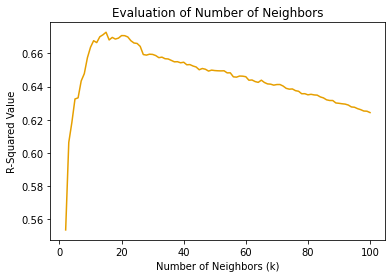

In [70]:
# Get R-squared score against number of neighbors
ks = list(range(2, 101))
scores = []
for i in range(len(knn)):
    scores.append(knn[i].score(X_test, y_test))

# Plot graph
fig, ax = plt.subplots()
ax.plot(ks, scores, color=colors[0], alpha=1, label='R-Squared')
ax.set_xlabel('Number of Neighbors (k)')
ax.set_ylabel('R-Squared Value')
ax.set_title(f'Evaluation of Number of Neighbors')
plt.show()

# Appears around 15 neighbors is the ideal k

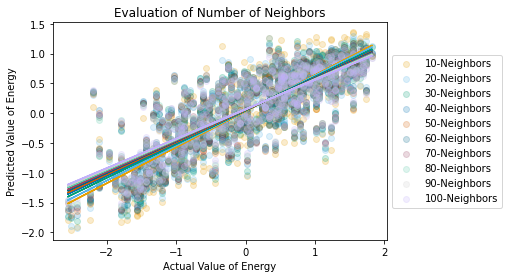

In [77]:
# Show comparison of predicted VS actual values for all models
#   (Only every 10th model)

# Plot graph
fig, ax = plt.subplots()
j = 0
for i in range(10, 101, 10):
    prediction = predictions[i-2]
    ax.scatter(y_test, prediction, color=colors[j], alpha=0.2, label=f'{i}-Neighbors')
    a, b = np.polyfit(y_test, prediction, 1)
    ax.plot(y_test, a * y_test + b, color=colors[j])
    j += 1
ax.set_xlabel('Actual Value of Energy')
ax.set_ylabel('Predicted Value of Energy')
ax.set_title('Evaluation of Number of Neighbors')
ax.legend(facecolor='white', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()